# BRAIN TUMOR CLASSIFICATION 
data set : https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

# importing all the libraries 

In [2]:
import tensorflow as tf
from  tensorflow.keras import models ,layers
import matplotlib.pyplot as plt 
from IPython.display import HTML

In [3]:
BATCH_SIZE =  32
IMAGE_SIZE = 256
CHANNEL = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "brain_tumor data set",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 7023 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 3 1 2 0 1 0 1 2 3 2 3 0 2 3 1 1 0 0 3 1 2 3 3 2 3 0 1 3 0 3 0]


# lets visualize some of the pictures 

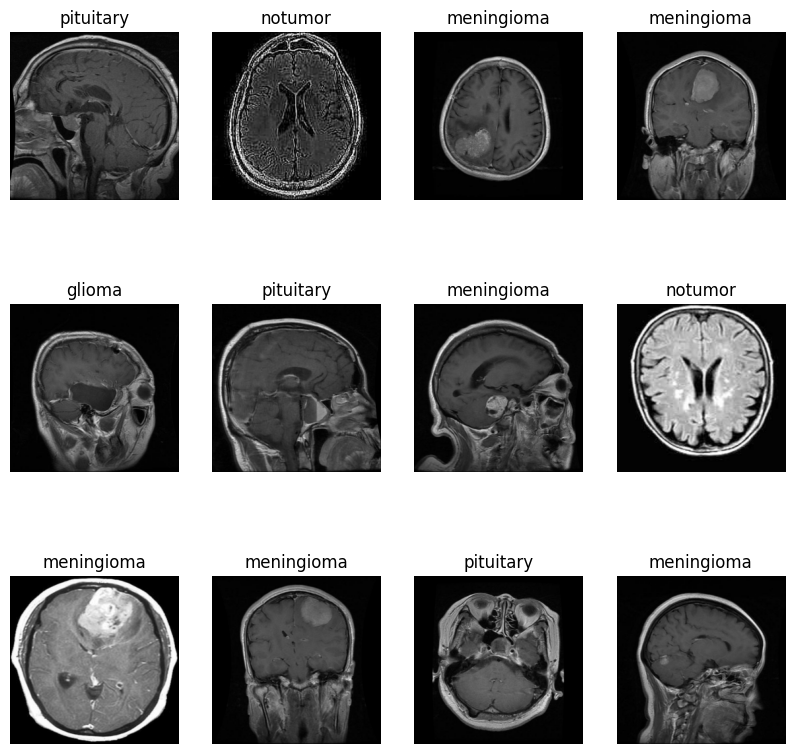

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    

# lets divide the data into 3 parts ,training , testing , validation part .

In [11]:
len(dataset)

220

In [12]:
train_size = 0.8
len(dataset)*train_size # hence out of 220 we take 176 images as the training images 

176.0

In [13]:
train_ds = dataset.take(176)
len(train_ds)

176

In [15]:
test_ds =  dataset.skip(176)
len(test_ds)

44

In [16]:
val_size = 0.1
len(dataset)*val_size

22.0

In [18]:
val_ds = test_ds.take(22)
len(val_ds)

22

In [19]:
test_ds = test_ds.skip(22)
len(test_ds)

22

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
print("length of train data :",len(train_ds))
print("length of validation data set :",len(val_ds))
print("length of test daa set :",len(test_ds))

length of train data : 176
length of validation data set : 22
length of test daa set : 22


# lets perform some of the operations on the data

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

# lets perform normalization (resizing) keeping the data in the range of 0-1

In [26]:
from tensorflow.keras.layers import Resizing , Rescaling
resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),   
])


# lets perform argumentation 

In [27]:
from tensorflow.keras.layers import RandomRotation , RandomFlip
data_argumentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

# applying the augmentation to the training data

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_argumentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# lets fit the data

In [47]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9139 - loss: 0.2346 - val_accuracy: 0.9006 - val_loss: 0.2672
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 136s 770ms/step - accuracy: 0.9020 - loss: 0.2686 - val_accuracy: 0.9403 - val_loss: 0.1700
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 144s 816ms/step - accuracy: 0.9217 - loss: 0.2197 - val_accuracy: 0.9261 - val_loss: 0.1891
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 130s 736ms/step - accuracy: 0.9252 - loss: 0.2114 - val_accuracy: 0.9134 - val_loss: 0.2076
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 131s 743ms/step - accuracy: 0.9156 - loss: 0.2178 - val_accuracy: 0.9432 - val_loss: 0.1599
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 129s 735ms/step - accuracy: 0.9283 - loss: 0.1943 - val_accuracy: 0.9517 - val_loss: 0.1392
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 130s 737ms/step - accuracy: 0.9340 - loss: 0.1979 - val_accuracy: 0.9531 - val_loss: 0.1492
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 133s 754ms/step - accuracy: 0.9380 - lo

In [49]:
scores = model.evaluate(test_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 290ms/step - accuracy: 0.9683 - loss: 0.1026


In [46]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# lets perform prediction

first image to predict
actual label: notumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
predicted label: notumor


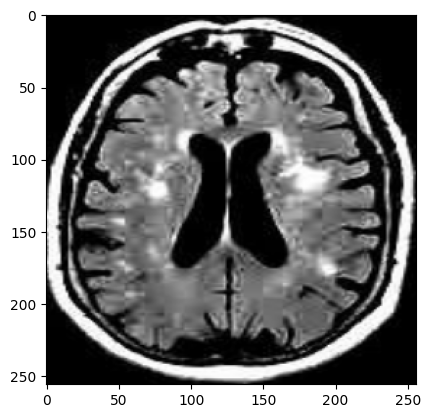

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
print( )

# lets perform the predictions on some samples . 


In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


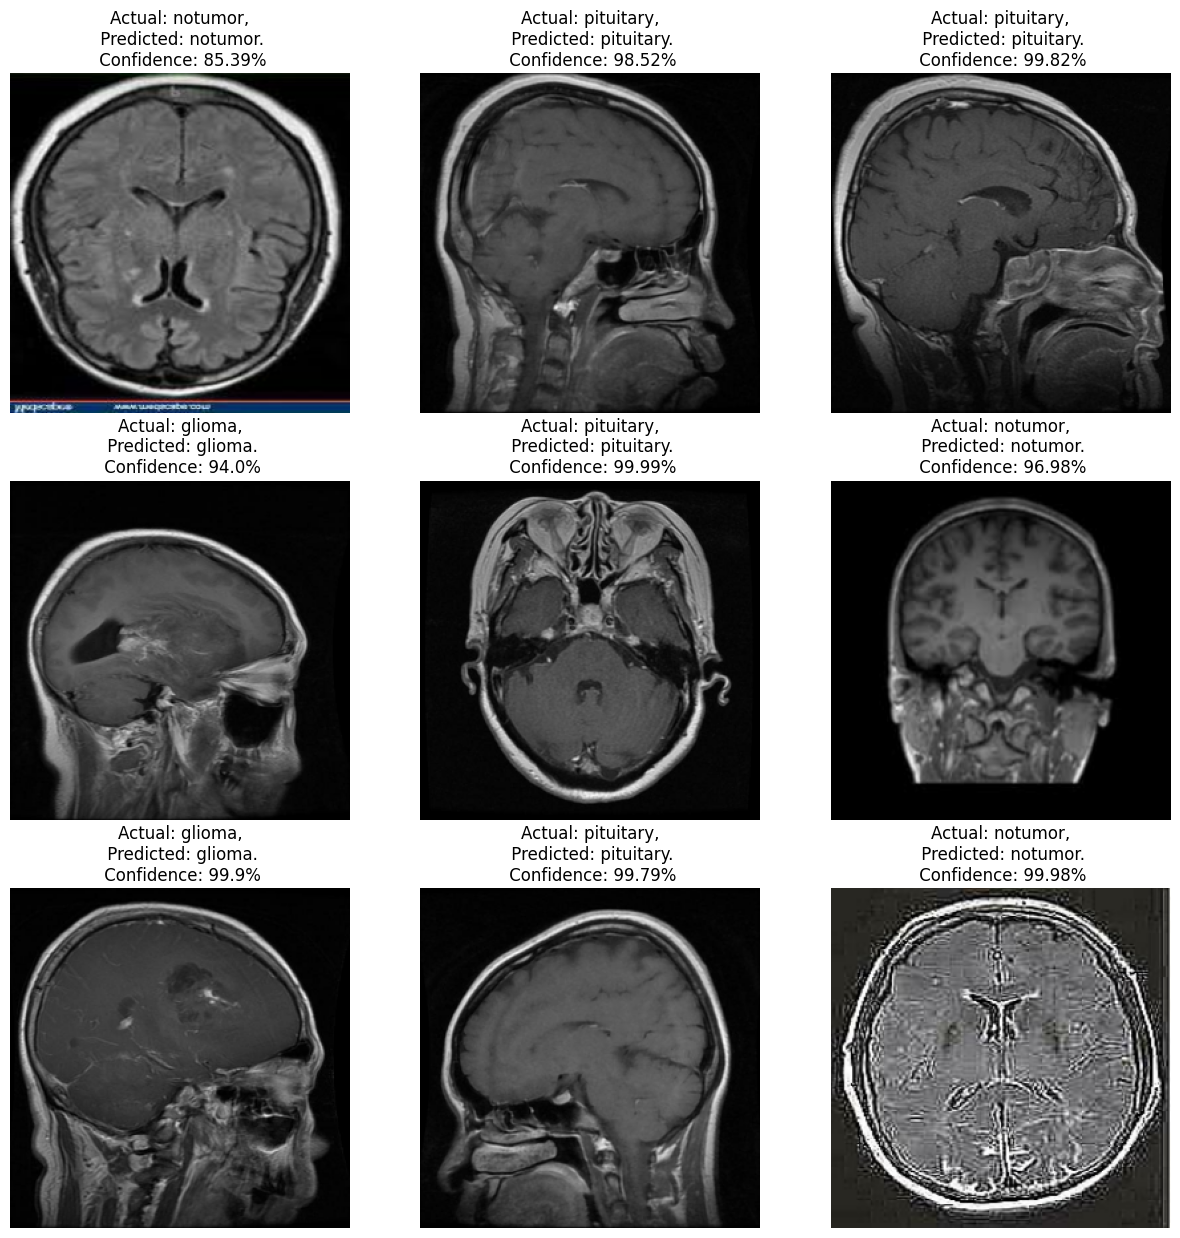

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [1]:
model.save("C:/Users/krish/OneDrive/Desktop/potato_desease/model.h5")
# C:\Users\krish\OneDrive\Desktop\potato_desease

NameError: name 'model' is not defined